In [18]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from functools import partial
import control
from GPR import *
from TVGPR import *
# from reach import *

# Some configurations
jax.config.update("jax_enable_x64", True)

# We wrap the jax.jit function t/o set the backend to cpu by default for convenience.
device = 'cpu'
def jit (*args, **kwargs):
    kwargs.setdefault('backend', device)
    return jax.jit(*args, **kwargs)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 14
})

np.random.seed(0)

In [19]:
import immrax as irx

In [20]:
# system dynamics and initial conditions

class PlanarMultirotorTransformed (irx.System) :
    def __init__ (self) :
        self.xlen = 5
        self.evolution = 'continuous'

    def f(self, t, x, u, w):
        px, py, h, v, theta = x.ravel()
        # u1, u2 = u.ravel()
        u1 = u[0]
        u2 = u[1]
        w1 = w[0]
        g = 9.81

        return jnp.array([
            h*jnp.cos(theta) - v*jnp.sin(theta),
            h*jnp.sin(theta) + v*jnp.cos(theta),
            -g*jnp.sin(theta) + w1*jnp.cos(theta),
            u1 - g*jnp.cos(theta) - w1*jnp.sin(theta),
            u2
        ])
    
    def f_np(self, t, x, u, w):
        px, py, h, v, theta = x.ravel()
        u1 = u[0]
        u2 = u[1]
        w1 = w[0]
        g = 9.81

        return np.array([
            h*np.cos(theta) - v*np.sin(theta),
            h*np.sin(theta) + v*np.cos(theta),
            -g*np.sin(theta) + w1*np.cos(theta),
            u1 - g*np.cos(theta) - w1*np.sin(theta),
            u2
        ])

sys = PlanarMultirotorTransformed()

# initial conditions
x0 = jnp.array([-4., 6., 0., 0., 0.1])
u0 = jnp.array([9.81, 0.0])

w0 = jnp.array([0.0])

# x0_buf = 0.05 * jnp.array([1.0, 1.0, 1.0, 1.0, 1.0])
x0_buf = jnp.array([0.01, 0.01, 0.01, 0.01, 0.01])
ix0 = irx.icentpert(x0, x0_buf)
print(f"{ix0=}")

ulim = irx.interval([-5, -5],[15, 5])

former_disturbance_GP = GPR(jnp.array([[-2,-0.66005468347438],
                                       [0,1.71910828159421],
                                       [2,-2.73909534657961],
                                       [4,3.76474225408493],
                                       [6,3.65733558594356],
                                       [8,-0.116994810217270],
                                       [10,2.40224375111040],
                                       [12,-2.86490929098228]]), 
                                       sigma_f = 5.0, 
                                       l=2.0, 
                                       sigma_n = 0.01)
actual_disturbance_GP = TVGPR(jnp.array([[0, -2,-0.66005468347438],
                                       [0, 0,1.71910828159421],
                                       [0, 2,-2.73909534657961],
                                       [0, 4,3.76474225408493],
                                       [0, 6,3.65733558594356],
                                       [0, 8,-0.116994810217270],
                                       [0, 10,2.40224375111040],
                                       [0, 12,-2.86490929098228],
                                    #    [16, -2,2.80494480741922],
                                    #    [16, 0,-1.65967058757266],
                                    #    [16, 2,-2.21529178685802],
                                    #    [16, 4,-2.41828274757721],
                                    #    [16, 6,-0.976879063072681],
                                    #    [16, 8,-2.89172701466510],
                                    #    [16, 10,-3.91337304908981],
                                    #    [16, 12,-3.33944976072828],
                                       ]), 
                                       sigma_f = 5.0, 
                                       l=2.0, 
                                       sigma_n = 0.01,
                                       epsilon=0.1,
                                       discrete=False
                                       )


def actual_disturbance_test (t, x, epsilon=0.1) :
    return actual_disturbance_GP.mean(jnp.array([t, x[1]])).reshape(-1)

#sanity check: these should be the same if TVGPR discrete = false
print(f"{actual_disturbance_test(0.0, x0)=}")
print(f"{former_disturbance_GP.mean(jnp.array([x0[1]])).reshape(-1)=}")

# GP = GPR(jnp.array([[1., 1.], [2., 1.0], [0., 1.]]), sigma_f = 1.0, l=2.0, sigma_n = 0.01)

# GP = GPR(jnp.array([[0.0, 1.], [1.0, 1.0], [-1.0, 0.5], [2.0, 1.0]]))
# GP = GPR(jnp.array([[0.0, 1.], [1.0, 1.0], [-1.0, 0.5], [0.5, 1.], [0.75, 0.5], [0.25, 1.]]), l=1.)

# DEBUGGING GP
# print(GP.x)
# print(GP.y)
# # print(np.sqrt(GP.variance(jnp.array([x0[1]])).reshape(-1)))
# def sigma(t, x):
#     return jnp.sqrt(GP.variance(jnp.array([x[1]])).reshape(-1))

# @jit
# def sigma_bruteforce_if(t, ix):
#     div = 100
#     x_list = [ix.lower + ((ix.upper - ix.lower)/div)*i for i in range(div)]
#     sigma_list = 3.0*jnp.array([sigma(t, x) for x in x_list])
#     return irx.interval(jnp.array([jnp.min(sigma_list)]), jnp.array([jnp.max(sigma_list)]))

# print(sigma(0.0, ix0.lower)) 
# print(sigma(0.0, ix0.upper)) 
# # for i in range(100):
#     # print(sigma(0.0, ix0.lower + ((ix0.upper - ix0.lower)/100)*i))
# # sigma_list = [sigma(0.0, ix0.lower + ((ix0.upper - ix0.lower)/1000)*i) for i in range(1000)]
# # print(np.min(sigma_list), np.max(sigma_list))
# print(sigma_bruteforce_if(0.0, ix0))
# # print(irx.natif(sigma)(0.0, ix0))

# sigma_if = lambda t, x : irx.icentpert(0.0, irx.natif(sigma)(t, x).upper)
# print(sigma_if(0.0, ix0))


ix0=[-4.01  5.99 -0.01 -0.01  0.09] <= x <= [-3.99  6.01  0.01  0.01  0.11]
actual_disturbance_test(0.0, x0)=Array([3.65728629], dtype=float64)
former_disturbance_GP.mean(jnp.array([x0[1]])).reshape(-1)=Array([3.65728629], dtype=float64)


In [21]:
obs = jnp.array([[0, x0[1], actual_disturbance_test(0.0, x0)[0]], 
                    [0, x0[1], actual_disturbance_test(0.0, x0)[0]], 
                    [0, x0[1], actual_disturbance_test(0.0, x0)[0]],
                    [0, x0[1], actual_disturbance_test(0.0, x0)[0]],
                    [0, x0[1], actual_disturbance_test(0.0, x0)[0]],
                    [0, x0[1], actual_disturbance_test(0.0, x0)[0]],
                    [0, x0[1], actual_disturbance_test(0.0, x0)[0]],
                    [0, x0[1], actual_disturbance_test(0.0, x0)[0]],
                    [0, x0[1], actual_disturbance_test(0.0, x0)[0]]])

# obs = jnp.array([[0.,         6. ,        3.65728629],
#  [0.   ,      6.     ,    3.65728629],
#  [0.    ,     6.    ,     3.65728629],
#  [0.     ,    6.   ,      3.65728629],
#  [0.      ,   6.  ,       3.65728629],
#  [0.       ,  6. ,        3.65728629],
#  [0.36      , 5.57207151 ,4.76719219]])

testGPR = TVGPR(obs)
print(f"{testGPR.mean(jnp.hstack((10.0, x0[1]))).reshape(-1)=}")
def test_disturbance(t, x):
    return testGPR.mean(jnp.hstack((10.0, x[1]))).reshape(-1)
print(f"{test_disturbance(0, x0)=}")
test_mjacM = irx.mjacM(test_disturbance)
test_perm = irx.Permutation((0, 1, 2, 4, 5, 3))
t_int = irx.interval([10.0])
print(f"{t_int=}")
print(f"{ix0=}")
TEST_MG = test_mjacM(irx.interval(jnp.array([0.])), ix0, 
                         centers=((jnp.array([0.]), x0,),), 
                         permutations=(test_perm,))
print(TEST_MG)

testGPR.mean(jnp.hstack((10.0, x0[1]))).reshape(-1)=Array([2.15959084], dtype=float64)
test_disturbance(0, x0)=Array([2.15959084], dtype=float64)
t_int=[10.] <= x <= [10.]
ix0=[-4.01  5.99 -0.01 -0.01  0.09] <= x <= [-3.99  6.01  0.01  0.01  0.11]
[[Array([[0.]], dtype=float64), [[ 0.         -0.02159591  0.          0.          0.        ]] <= x <= [[0.         0.02159591 0.         0.         0.        ]]]]


def mean_disturbance (t, x) :
    return GP.mean(jnp.array([x[1]])).reshape(-1)
    # return GP.mean(x[(0,),])
print(ix0[(0,),])
print(x0[0])

def tr (x) :
    # return x[(0,),]
    return jnp.array([x[0]])

# print(tr(ix0))
print(irx.natif(tr)(ix0))
print(mean_disturbance(0.0, x0))
print(sigma_bruteforce_if(0.0, ix0))

In [22]:
# determinant helper function, can't use np.linalg.det because it uses a primitive not in immrax
def getDet(mat, n=5):
  
    # Base case: if the matrix is 1x1
    if n == 1:
        return mat[0][0]
    
    # Base case for 2x2 matrix
    if n == 2:
        return mat[0][0] * mat[1][1] - \
               mat[0][1] * mat[1][0]
    
    # Recursive case for larger matrices
    res = 0
    for col in range(n):
      
        # Create a submatrix by removing the first 
        # row and the current column
        sub = [[0] * (n - 1) for _ in range(n - 1)]
        for i in range(1, n):
            subcol = 0
            for j in range(n):
              
                # Skip the current column
                if j == col:
                    continue
                
                # Fill the submatrix
                sub[i - 1][subcol] = mat[i][j]
                subcol += 1
        
        # Cofactor expansion
        sign = 1 if col % 2 == 0 else -1
        res += sign * mat[0][col] * getDet(sub, n - 1)
    
    return res

In [23]:
# Get initial P, K from LQR

# linearize system around x0, u0
A, B = jax.jacfwd(lambda x: sys.f(0, x, u0, [0]))(x0), jax.jacfwd(lambda u: sys.f(0, x0, u, [0]))(u0)
# print(A)
# print(B)

# weight matrices
Q = jnp.array([1, 1, 1, 1, 1]) * jnp.eye(sys.xlen)
R = jnp.array([1, 1]) * jnp.eye(2)

# LQR to get initial K, P
K, P, _ = control.lqr(A, B, Q, R)
feedback_K = -1 * K
print(feedback_K)

# A, B = jax.jacfwd(lambda x: sys.f(0, x, u0, [0]))(x0*0.0), jax.jacfwd(lambda u: sys.f(0, x0, u, [0]))(u0)
A = jnp.array([[0, 0, 1, 0, 0], 
               [0, 0, 0, 1, 0], 
               [0, 0, 0, 0, -9.81], 
               [0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0]])
B = jnp.array([[0, 0], 
               [0, 0], 
               [0, 0], 
               [1, 0], 
               [0, 1]])
Q = jnp.array([1000, 20, 500, 500, 1]) * jnp.eye(sys.xlen)
R = jnp.array([20, 20]) * jnp.eye(2)
K, P, _ = control.lqr(A, B, Q, R)
backup_K = -1 * K
print(backup_K)


[[ 0.03762342 -0.99929199 -0.12853876 -1.72950908 -0.07007061]
 [ 0.99929199  0.03762342  1.45085207 -0.07007061 -5.42732413]]
[[ -0.          -1.          -0.          -5.19615242  -0.        ]
 [  7.07106781  -0.           6.4170833   -0.         -11.22288618]]


In [24]:
# Simulation parameters
t0 = 0.     # Initial time
dt = 0.01  # Time step

T = 30.0   # Horizon for one step of the algorithm
tt = np.arange(t0, T+dt, dt)
# print(tt)
# T = 0.1
# N = 5       # Number of iterations of the algorithm
# tf = T*N    # Final time

sys_mjacM = irx.mjacM(sys.f)
sys_jacM = irx.jacM(sys.f)

perm = irx.Permutation((0, 1, 2, 3, 4, 5, 6, 7, 8))

# G_mjacM = irx.mjacM(mean_disturbance)
# G_jacM = irx.jacM(mean_disturbance)
# G_perm = irx.Permutation((0, 1, 3, 4, 5, 2))

# sigma_mjacM = irx.mjacM(sigma)
# sigma_jacM = irx.jacM(sigma)
# sigma_perm = irx.Permutation((0, 1, 3, 4, 5, 2))

# print(sigma(0.0, x0)) 

# sigma_if = lambda t, x : irx.icentpert(0.0, irx.natif(sigma)(t, x).upper)

# print(sigma_if(0.0, ix0))

# def upper_bound(t, x):
#     return GP.mean(jnp.array([x[1]])).reshape(-1) + sigma(t, x)#jnp.sqrt(GP.variance(jnp.array([x[1]])).reshape(-1))

# def lower_bound(t, x):
#     return GP.mean(jnp.array([x[1]])).reshape(-1) - sigma(t, x)#jnp.sqrt(GP.variance(jnp.array([x[1]])).reshape(-1))

# dist_if = lambda t, x : irx.interval(irx.natif(lower_bound)(t, x).lower, irx.natif(upper_bound)(t, x).upper)  
# test_interval = irx.icentpert(x0, jnp.array([1, 1, 1, 1, 1]))
# print(dist_if(0.0, test_interval))
# print(mean_disturbance(0.0, x0))
# print(dist_if(0.0, test_interval) - mean_disturbance(0.0, x0))

In [25]:

@partial(jit, static_argnames=('mjacM',))
def rollout (t_init, ix, xc, K_feed, K_backup, obs, mjacM=True) :
    # mjacM=True
    def mean_disturbance (t, x) :
            return GP.mean(jnp.hstack((t, x[1]))).reshape(-1)    

    def sigma(t, x):
        return jnp.sqrt(GP.variance(jnp.hstack((t, x[1]))).reshape(-1))

    def sigma_bruteforce_if(t, ix):
        div = 100
        x_list = [ix.lower + ((ix.upper - ix.lower)/div)*i for i in range(div)]
        sigma_list = 3.0*jnp.array([sigma(t, x) for x in x_list])
        return irx.interval(jnp.array([jnp.min(sigma_list)]), jnp.array([jnp.max(sigma_list)]))
        
    def step (carry, t) :
        xtut, xnomt, M, uM, wM, G, sig_range, MS, it = carry
        # uint = irx.icentpert(unomt, 1)
        # unomt = jnp.array([9.0 + 0.1*t, 0.1])
        ubackup = (K_backup @ xnomt) + jnp.array([9.81, 0.0])
        unomt = jnp.array([jnp.minimum(jnp.maximum(ubackup[0], ulim.lower[0]), ulim.upper[0]),
            jnp.minimum(jnp.maximum(ubackup[1], ulim.lower[1]), ulim.upper[1])])
        # print(unomt)

        # test values
        # wnomt = jnp.array([0.0])
        # wint = irx.icentpert(wnomt, jnp.array([1.]))
        
        wnomt = GP.mean(jnp.array([t, xnomt[1]])).reshape(-1)
        # sigma_int = irx.icentpert(0.0, sigma(t, xnomt))
        # wint = irx.interval(wnomt) + sigma_if(t, irx.ut2i(xtut))
        # wint = dist_if(t, irx.ut2i(xtut))
        # w_diff = wint - wnomt

        # buffer sampled sigma bound with lipschitz constant to recover guarantee
        xint = irx.ut2i(xtut)
        x_div = (xint.upper - xint.lower)/(100*2)
        sigma_lip = MS @ x_div.T

        # w_diff = sigma_if(t, irx.ut2i(xtut)) 
        w_diff = sigma_bruteforce_if(t, irx.ut2i(xtut))
        w_diffint = irx.icentpert(0.0, w_diff.upper + sigma_lip.upper[1])
        wint = irx.interval(wnomt) + w_diffint

        

        if mjacM :
            Mt, Mx, Mu, Mw = sys_mjacM(irx.interval(t), irx.ut2i(xtut), ulim, wint,
                                centers=((jnp.array([t]), xnomt, unomt, wnomt),), 
                                permutations=(perm,))[0]
            _, MG = G_mjacM(irx.interval(jnp.array([t])), irx.ut2i(xtut), 
                         centers=((jnp.array([t]), xnomt,),), 
                         permutations=(G_perm,))[0]
            # _, MS = sigma_mjacM(irx.interval(0.), irx.ut2i(xtut), 
            #              centers=((jnp.array([0.]), xnomt),), 
            #              permutations=(sigma_perm,))[0]
            # print(MG)
        else :
            # Mt, Mx = sys_mjacM(irx.interval(0.), irx.ut2i(xtut), 
            #                     centers=((jnp.array([0.]), xnomt),), 
            #                     permutations=(perm,))[0]
            # _Mt, _Mx = sys_jacM(irx.interval(0.), irx.ut2i(xtut))
            Mt, Mx, Mu, Mw = sys_jacM(irx.interval(0.), irx.ut2i(xtut), ulim, wint)
            _, MG = G_jacM(irx.interval(0.), irx.ut2i(xtut))
            # _, MS = sigma_mjacM(irx.interval(0.), irx.ut2i(xtut))

        Mt = irx.interval(Mt)
        Mx = irx.interval(Mx)
        Mu = irx.interval(Mu)
        Mw = irx.interval(Mw)
        # MG = irx.interval(MG)

        # F = lambda t, x, u : (Mx + Mu@K)@(x - xnomt) + Mu@(unomt) + sys.f(0., xnomt, unomt) # not 100% sure about this
        
        # F = lambda t, x, u, w : (Mx + Mu@K)@(x - xnomt) + Mw@(w - wnomt) + sys.f(0., xnomt, unomt, wnomt) # without GP Jac
        F = lambda t, x, u, w: (Mx + Mu@K_feed + Mw@MG)@(x - xnomt) + Mw@w_diffint + sys.f(0., xnomt, unomt, wnomt) # with GP Jac
        
        # F = irx.natif(sys.f)
        embsys = irx.ifemb(sys, F)
        xnomtp1 = xnomt + dt*sys.f(t, xnomt, unomt, wnomt)
        xtutp1 = xtut + dt*embsys.E(irx.interval(jnp.array([t])), xtut, unomt, wint)

        
        # MG = jax.jacfwd(mean_disturbance, argnums=(1,))(0., xnomt)[0][0]
        return ((xtutp1, xnomtp1, M|Mx, uM|Mu, wM|Mw, G|MG, sig_range|w_diff, MS, it + 1), (xtutp1, xnomtp1, unomt))
    # unomt = jnp.array(u0)
    GP = TVGPR(obs, sigma_f = 5.0, l=2.0, sigma_n = 0.01, epsilon = 0.25)
    # GP = GPR(obs[:, 1:], sigma_f = 5.0, l=2.0, sigma_n = 0.01)
    tt = jnp.arange(0, T, dt) + t_init
    J0 = jax.jacfwd(sys.f, argnums=(1,))(t_init, xc, u0, w0)[0]
    Ju = jax.jacfwd(sys.f, argnums=(2,))(t_init, xc, u0, w0)[0]
    Jw = jax.jacfwd(sys.f, argnums=(3,))(t_init, xc, u0, w0)[0]
    G0 = jax.jacfwd(mean_disturbance, argnums=(1,))(t_init, xc)[0]
    sig0 = irx.icentpert(0.0, sigma(t_init, xc))
    MS0 = jax.jacfwd(sigma, argnums=(1,))(t_init, xc)[0]
    G_mjacM = irx.mjacM(mean_disturbance)
    G_jacM = irx.jacM(mean_disturbance)
    G_perm = irx.Permutation((0, 1, 2, 4, 5, 3))

    carry, xx = jax.lax.scan(step, (irx.i2ut(ix), xc, irx.interval(J0), irx.interval(Ju), irx.interval(Jw), irx.interval(G0), sig0, irx.interval(MS0), 0), tt)
    # return jnp.vstack((irx.i2ut(ix), xx[0])), jnp.vstack((xc, xx[1])), carry[2], carry[3], carry[4], jnp.vstack((u0, xx[2])), carry[5], carry[6]
    return jnp.vstack((irx.i2ut(ix), xx[0])), jnp.vstack((xc, xx[1])), jnp.vstack(xx[2])

# xx, xxnom, M, Mu, Mw, unom_arr, G, sig_range = rollout(ix0, x0, K, u_ref)
xx, xxnom, unom_arr = rollout(0.0, ix0, x0, feedback_K, backup_K, obs)
print(xx.shape)
print(xxnom.shape)
print(unom_arr.shape)

# print(M.shape)
# print(Mu.shape)
# print(Mw.shape)
# print(unom_arr.shape)
# print(G)
# if np.any(np.isnan(np.array(G.lower))) : raise ValueError("NaN in G")
# print(sig_range)
# print((Mw@G).shape)

(3001, 10)
(3001, 5)
(3000, 2)


In [10]:
xx, xxnom, unom_arr= rollout(0.0, ix0, x0, feedback_K, backup_K, obs)

In [11]:
#timing analysis
for i in range(100):
    xx, xxnom, unom_arr = rollout(0.0, ix0, x0, feedback_K, backup_K, obs)

In [ ]:
# feed it ref and emb -> gives you 
def collection_id(xref, xemb, threshold=0.3):
    for i in range(xref.shape[0]):
        # print(i)
        # print(np.abs(xref[i, :] - xemb[i, :5]))
        # print(np.abs(xref[i, :] - xemb[i, 5:]))
        if any(np.abs(xref[i, :] - xemb[i, :5]) > threshold) or any(np.abs(xref[i, :] - xemb[i, 5:]) > threshold) or any(np.isnan(xref[i, :])) or any(np.isnan(xemb[i, :5])) or any(np.isnan(xemb[i, :])):
            return i
    return -1

collection_id(xxnom, xx)

30

In [13]:
def quadplot(xpos,ypos,rot,scale):
    ts=-.5*np.arange(np.pi,3/2*np.pi,.2)+.3
    xtemp=np.cos(ts)
    ytemp=np.sin(ts)*np.cos(ts)

    xs=np.hstack((.4*xtemp-1,-1,-1,1,1,.4*xtemp+1))
    ys=np.hstack((.3*ytemp+.4,.4,0,0,.4,.3*ytemp+.4))
    xs=scale*xs
    ys=scale*ys
    rotmat=np.array([[np.cos(rot),-np.sin(rot)],[np.sin(rot),np.cos(rot)]])
    # print(xs)
    newpos=rotmat@np.vstack((xs,ys))
    xs=newpos[0,:]+xpos
    ys=newpos[1,:]+ypos
    return xs,ys

quadplot(0, 0, 0, 1)

(array([-0.88179192, -0.92053227, -0.96006663, -1.        , -1.03993337,
        -1.07946773, -1.11820808, -1.15576734, -1.        , -1.        ,
         1.        ,  1.        ,  1.11820808,  1.07946773,  1.03993337,
         1.        ,  0.96006663,  0.92053227,  0.88179192,  0.84423266]),
 array([0.31530363, 0.34158725, 0.3701996 , 0.4       , 0.4298004 ,
        0.45841275, 0.48469637, 0.50760341, 0.4       , 0.        ,
        0.        , 0.4       , 0.31530363, 0.34158725, 0.3701996 ,
        0.4       , 0.4298004 , 0.45841275, 0.48469637, 0.50760341]))

In [16]:
# # RUN SIMULATION AND SAVE ANIMATION
# import matplotlib.animation as animation


# def u_applied(x, xref, uref, K_feedback):
#     ubackup = (K_feedback @ (xref - x)) + uref
#     unomt = np.array([np.minimum(np.maximum(ubackup[0], ulim.lower[0]), ulim.upper[0]),
#             np.minimum(np.maximum(ubackup[1], ulim.lower[1]), ulim.upper[1])])
#     return unomt


# current_state = x0
# current_int = irx.icentpert(current_state, x0_buf)
# current_time = 0.0
# traj_idx = 0
# sim_dt = 0.05
# sim_length = 20.0
# thresh = 0.3


# # setup disturbance behavior
# np.random.seed(0)
# actual_disturbance_GP_f = GPR(jnp.array([[-2,-0.66005468347438],
#                                        [0,1.71910828159421],
#                                        [2,-2.73909534657961],
#                                        [4,3.76474225408493],
#                                        [6,3.65733558594356],
#                                        [8,-0.116994810217270],
#                                        [10,2.40224375111040],
#                                        [12,-2.86490929098228],
#                                        ]), 
#                                        sigma_f = 5.0, 
#                                        l=2.0, 
#                                        sigma_n = 0.01
#                                        )
# actual_disturbance_GP_g = GPR(jnp.array([[-2,2.80494480741922],
#                                        [0,-1.65967058757266],
#                                        [2,-2.21529178685802],
#                                        [4,-2.41828274757721],
#                                        [6,-0.976879063072681],
#                                        [8,-2.89172701466510],
#                                        [10,-3.91337304908981],
#                                        [12,-3.33944976072828],
#                                        ]),
#                                         sigma_f = 5.0,
#                                         l=2.0,
#                                         sigma_n = 0.01,
#                                         )
# dist_f_time = 0.0
# dist_update_mag = 1.5

# def actual_disturbance (t, x, epsilon=0.25) :
#     t_leftover = t % 1.0
#     cur_val = actual_disturbance_GP_f.mean(jnp.array([x[1]])).reshape(-1)
#     next_val = jnp.sqrt(1-epsilon)*actual_disturbance_GP_f.mean(jnp.array([x[1]])).reshape(-1) + jnp.sqrt(epsilon)*actual_disturbance_GP_g.mean(jnp.array([x[1]])).reshape(-1)
#     return (1.0 - t_leftover)*cur_val + t_leftover*next_val

# obs = jnp.array([[0., x0[1], actual_disturbance(0.0, x0)[0]], 
#                     [0., x0[1], actual_disturbance(0.0, x0)[0]], 
#                     [0., x0[1], actual_disturbance(0.0, x0)[0]],
#                     [0., x0[1], actual_disturbance(0.0, x0)[0]],
#                     [0., x0[1], actual_disturbance(0.0, x0)[0]],
#                     [0., x0[1], actual_disturbance(0.0, x0)[0]],
#                     [0., x0[1], actual_disturbance(0.0, x0)[0]],
#                     [0., x0[1], actual_disturbance(0.0, x0)[0]],
#                     [0., x0[1], actual_disturbance(0.0, x0)[0]]])

# xx, xxnom, unom_arr = rollout(current_time, current_int, current_state, feedback_K, backup_K, obs)
# t_arr = np.arange(current_time, current_time + T, dt)
# t_index = collection_id(xxnom, xx, thresh)
# collection_time = t_arr[t_index]
# applied_input = u_applied(current_state, xxnom[traj_idx, :], unom_arr[traj_idx, :], feedback_K)
# flight_path = np.array([x0])


# PLOT_OBS = True

# # PLOTTING
# if PLOT_OBS:
#     fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# else:
#     fig, ax = plt.subplots()

# # wind disturbance
# arrow_points = np.mgrid[-4:4, -1:10].reshape(2, -1).T
# arrow_dirs = arrow_points*0.0
# for a in range(arrow_points.shape[0]):
#     arrow_dirs[a, :] = [actual_disturbance(0.0, np.array([arrow_points[a, 0], arrow_points[a, 1], 0.0, 0.0, 0.0]))[0], 0.0]
# wind_arrows = ax.quiver(arrow_points[:, 0], arrow_points[:, 1], arrow_dirs[:, 0], arrow_dirs[:, 1], color='tab:gray', alpha=0.5)

# # mixed monotonicity tube
# # t_index = int(t_star/dt)
# t_index_plot = t_index + 1 # plot up to deviation
# nominal = ax.plot(xxnom[:t_index_plot,0], xxnom[:t_index_plot,1], label='Reference Trajectory', linestyle="dashed", color="black", linewidth=0.5)[0]
# lower = ax.plot(xx[:t_index_plot+1,0], xx[:t_index_plot+1,1], label='Lower', color="tab:red")[0]
# upper = ax.plot(xx[:t_index_plot+1,5], xx[:t_index_plot+1,6], label='Upper', color = "tab:blue")[0]

# # actual = ax.plot(xa[:t_index,0], xa[:t_index,1], label='Actual', linestyle="dashed")[0]
# # flight = ax.plot(x0[0], x0[1], label='Flight Trajectory', color='black')[0]

# start_rect = Rectangle((xx[0,0], xx[0,1]), xx[0,5] - xx[0,0], xx[0,6] - xx[0,1], linewidth=1, edgecolor='tab:gray', facecolor='none', linestyle="dashed")
# start_patch = ax.add_patch(start_rect)
# # end_rect = Rectangle((xx[-1,0], xx[-1,1]), xx[-1,5] - xx[-1,0], xx[-1,6] - xx[-1,1], linewidth=1, edgecolor='tab:gray', facecolor='none', linestyle="dashed")
# end_rect = Rectangle((xx[t_index_plot,0], xx[t_index_plot+1,1]), xx[t_index_plot+1,5] - xx[t_index_plot+1,0], xx[t_index_plot+1,6] - xx[t_index_plot+1,1], linewidth=1, edgecolor='tab:gray', facecolor='none', linestyle="dashed")
# end_patch = ax.add_patch(end_rect)
# landing_rect = Rectangle((-0.5, -1.0), 1.0, 1.0, linewidth=1, edgecolor='tab:green', facecolor='tab:green')
# ax.add_patch(landing_rect)
# quad_x, quad_y = quadplot(x0[0], x0[1], x0[4], 0.1)
# quad = ax.plot(quad_x, quad_y, color='black')[0]

# plt.axes(ax)
# plt.xlabel('x')
# plt.ylabel('y')
# titletime = plt.title('t = %1.2f' % current_time)
# plt.legend(fontsize=8)
# plt.grid()
# # plt.gca().set_aspect('equal')
# plt.gca().set_xlim([-4, 4])
# plt.gca().set_ylim([-1, 10])

# if PLOT_OBS:
#     gp_query_points = np.array([[0.0, p] for p in np.linspace(-2, 12, 100)])
#     plotTVGP = TVGPR(obs, sigma_f = 5.0, l=2.0, sigma_n = 0.01, epsilon = 0.25)
#     mean_pts = jnp.array([plotTVGP.mean(gpqp) for gpqp in gp_query_points]).reshape(-1)
#     actual_pts = jnp.array([actual_disturbance(gpqp[0], jnp.array([0., gpqp[1], 0., 0., 0.]))[0] for gpqp in gp_query_points]).reshape(-1)
#     sig_pts = 3*jnp.array([jnp.sqrt(plotTVGP.variance(gpqp)) for gpqp in gp_query_points]).reshape(-1)
    
#     observations = ax2.scatter(obs[:, 1], obs[:, 2], label='Observations', c=obs[:, 0], cmap='viridis', s=100, edgecolors='black')
#     actual = ax2.plot(gp_query_points[:, 1], actual_pts, label='Actual', color='black')[0]
#     mean = ax2.plot(gp_query_points[:, 1], mean_pts, label='Mean', color='tab:blue')[0]
#     upper_conf = ax2.plot(gp_query_points[:, 1], mean_pts + sig_pts, label='Confidence Bound', color='lightblue')[0]
#     lower_conf = ax2.plot(gp_query_points[:, 1], mean_pts - sig_pts, color='lightblue')[0]


#     plt.axes(ax2)
#     plt.xlabel('y')
#     plt.ylabel('magnitude')
#     plt.title('Disturbance Behavior')
#     plt.legend(fontsize=8)
#     plt.grid()
#     # plt.gca().set_aspect('equal')
#     plt.gca().set_xlim([-2, 12])
#     plt.gca().set_ylim([-8, 8])

# def update(frame):
#     # apply input, update state/time
#     global current_state, applied_input, current_time, flight_path, collection_time, traj_idx, t_index, t_index_plot, obs, xxnom, xx, unom_arr, arrow_points, wind_arrows, actual_disturbance_GP_f, actual_disturbance_GP_g, dist_f_time, plotTVGP, mean, actual, PLOT_OBS, observations, upper, lower, dist_update_mag
#     print(frame)
#     print(current_state)
#     print(applied_input)
#     print(current_time)
#     print(collection_time)

#     for i in range(int(sim_dt/dt)):
#         # while current_time < current_time + sim_dt:
#         current_state = current_state + dt * sys.f_np(current_time, current_state, applied_input, actual_disturbance(current_time, current_state))
#         flight_path = np.vstack((flight_path, current_state))
#         current_int = irx.icentpert(current_state, x0_buf)
#         current_time = current_time + dt
#         traj_idx += 1
        
#         # if current_time >= collection_time, collect new observation and recompute
#         if current_time >= collection_time:
#             obs = jnp.vstack((obs[1:, :], jnp.array([[current_time, current_state[1], actual_disturbance(current_time, current_state)[0]]])))
#             if PLOT_OBS: plotTVGP = TVGPR(obs, sigma_f = 5.0, l=2.0, sigma_n = 0.01, epsilon = 0.25)
#             # print(obs)
#             xx, xxnom, unom_arr = rollout(current_time, current_int, current_state, feedback_K, backup_K, obs)
#             # print(xx)
#             t_arr = np.arange(current_time, current_time + T, dt)
#             t_index = collection_id(xxnom, xx, thresh)
#             t_index_plot = t_index + 10
#             collection_time = t_arr[t_index]    
            
#             traj_idx = 0

#         # if it's been 1 second, crete next portion of disturbance behavior
#         if current_time >= dist_f_time + 1.0:
#             dist_f_time = jnp.floor(current_time)
#             actual_disturbance_GP_f = GPR(jnp.array([[-2, actual_disturbance(0.99, [0, -2])[0]],
#                                        [0,actual_disturbance(0.99, [0, 0])[0]],
#                                        [2,actual_disturbance(0.99, [0, 2])[0]],
#                                        [4,actual_disturbance(0.99, [0, 4])[0]],
#                                        [6,actual_disturbance(0.99, [0, 6])[0]],
#                                        [8,actual_disturbance(0.99, [0, 8])[0]],
#                                        [10,actual_disturbance(0.99, [0, 10])[0]],
#                                        [12,actual_disturbance(0.99, [0, 12])[0]],
#                                        ]), 
#                                        sigma_f = 5.0, 
#                                        l=2.0, 
#                                        sigma_n = 0.01
#                                        )
#             actual_disturbance_GP_g = GPR(jnp.array([[-2, np.random.normal(scale=dist_update_mag)],
#                                         [0,np.random.normal(scale=dist_update_mag)],
#                                         [2,np.random.normal(scale=dist_update_mag)],
#                                         [4,np.random.normal(scale=dist_update_mag)],
#                                         [6,np.random.normal(scale=dist_update_mag)],
#                                         [8,np.random.normal(scale=dist_update_mag)],
#                                         [10,np.random.normal(scale=dist_update_mag)],
#                                         [12,np.random.normal(scale=dist_update_mag)],
#                                         ]),
#                                         sigma_f = 5.0,
#                                         l=2.0,
#                                         sigma_n = 0.01,
#                                         )
            

#         applied_input = u_applied(current_state, xxnom[traj_idx, :], unom_arr[traj_idx, :], feedback_K)
#     # t_index = -1
    
#     arrow_dirs = arrow_points*0.0
#     for a in range(arrow_points.shape[0]):
#         arrow_dirs[a, :] = [actual_disturbance(current_time, np.array([arrow_points[a, 0], arrow_points[a, 1], 0.0, 0.0, 0.0]))[0], 0.0]
#     wind_arrows.set_UVC(arrow_dirs[:, 0], arrow_dirs[:, 1])


#     nominal.set_data(xxnom[:,0], xxnom[:,1])
#     lower.set_data(xx[:t_index_plot+1,0], xx[:t_index_plot+1,1])
#     upper.set_data(xx[:t_index_plot+1,5], xx[:t_index_plot+1,6])
    
#     quad_x, quad_y = quadplot(current_state[0], current_state[1], current_state[4], 0.1)
#     quad.set_data(quad_x, quad_y)
#     # actual.set_data(xa[:t_index,0], xa[:t_index,1])
#     # flight.set_data(flight_path[:,0], flight_path[:,1])
#     start_patch.set_xy((xx[0,0], xx[0,1]))
#     start_patch.set_width(xx[0,5] - xx[0,0])
#     start_patch.set_height(xx[0,6] - xx[0,1])
#     end_patch.set_xy((xx[t_index_plot+1,0], xx[t_index_plot+1,1]))
#     end_patch.set_width(xx[t_index_plot+1,5] - xx[t_index_plot+1,0])
#     end_patch.set_height(xx[t_index_plot+1,6] - xx[t_index_plot+1,1])
    
#     titletime.set_text('t = %1.2f' % current_time)

#     if PLOT_OBS:
#         gp_query_points[:, 0] = current_time
#         mean_pts = jnp.array([plotTVGP.mean(gpqp) for gpqp in gp_query_points]).reshape(-1)
#         actual_pts = jnp.array([actual_disturbance(gpqp[0], jnp.array([0., gpqp[1], 0., 0., 0.]))[0] for gpqp in gp_query_points]).reshape(-1)
#         sig_pts = 3*jnp.array([jnp.sqrt(plotTVGP.variance(gpqp)) for gpqp in gp_query_points]).reshape(-1)
        
        
#         actual.set_data(gp_query_points[:, 1], actual_pts)
#         mean.set_data(gp_query_points[:, 1], mean_pts)
#         upper_conf.set_data(gp_query_points[:, 1], mean_pts + sig_pts)
#         lower_conf.set_data(gp_query_points[:, 1], mean_pts - sig_pts)
#         observations.set_offsets(obs[:, 1:])
#         observations.set_sizes(100*jnp.exp(2*(obs[:, 0] - current_time)))
#         observations.set_alpha(jnp.exp(1.0*(obs[:, 0] - current_time)))

        
    

#     return (nominal, lower, upper, quad, start_patch, end_patch, titletime)

# ani = animation.FuncAnimation(fig=fig, func=update, frames=int(sim_length/sim_dt), interval=int(sim_dt*1000))
# ani.save(filename="landing_sim_tvgp_withobs.gif", writer="pillow")

0
[-4.   6.   0.   0.   0.1]
[ 3.81 -5.  ]
0.0
0.3
0
[-3.99713859  5.99400286  0.18162241 -0.2683934  -0.14999466]
[ 5.2105162  -4.99958949]
0.05
0.3
1
[-3.9874462   5.97383875  0.47804753 -0.41872955 -0.39997344]
[ 6.01285725 -5.        ]
0.09999999999999999
0.3
2
[-3.97070379  5.93915415  0.87276728 -0.45317657 -0.64997344]
[ 6.23857443 -5.        ]
0.15
0.3
3
[-3.94709885  5.8871472   1.34247134 -0.37632595 -0.89997344]
[ 5.93454634 -5.        ]
0.20000000000000004
0.3
4
[-3.91885892  5.81342434  1.85801991 -0.19554763 -1.1428656 ]
[ 5.17257953 -3.11124296]
0.25000000000000006
0.3
5
[-3.88467983  5.71555609  2.38815235  0.04591257 -1.20448053]
[3.85587517 1.37388592]
0.3000000000000001
0.5500000000000003
6
[-3.82756927  5.59867555  2.92242289  0.22275372 -1.0820476 ]
[3.08358477 3.81668602]
0.35000000000000014
0.5500000000000003
7
[-3.73157529  5.47441414  3.45445219  0.29308364 -0.85911975]
[2.94157126 4.98322774]
0.4000000000000002
0.5500000000000003
8
[-3.58908888  5.35935223  3.

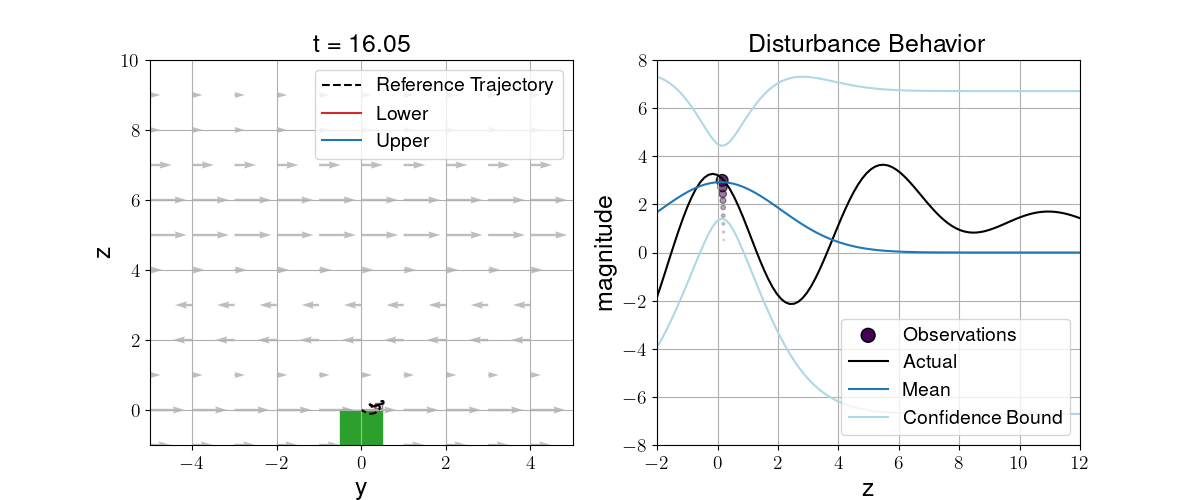

In [17]:
# RUN SIMULATION AND SAVE ANIMATION
import matplotlib.animation as animation
import tikzplotlib
 
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
 
Line2D._us_dashSeq    = property(lambda self: self._dash_pattern[1])
Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
Legend._ncol = property(lambda self: self._ncols)
 
 
def u_applied(x, xref, uref, K_feedback):
    ubackup = (K_feedback @ (xref - x)) + uref
    unomt = np.array([np.minimum(np.maximum(ubackup[0], ulim.lower[0]), ulim.upper[0]),
            np.minimum(np.maximum(ubackup[1], ulim.lower[1]), ulim.upper[1])])
    return unomt
 
 
current_state = x0
current_int = irx.icentpert(current_state, x0_buf)
current_time = 0.0
traj_idx = 0
sim_dt = 0.05
sim_length = 16.0
thresh = 0.3
 
 
# setup disturbance behavior
np.random.seed(0)
actual_disturbance_GP_f = GPR(jnp.array([[-2,-0.66005468347438],
                                       [0,1.71910828159421],
                                       [2,-2.73909534657961],
                                       [4,3.76474225408493],
                                       [6,3.65733558594356],
                                       [8,-0.116994810217270],
                                       [10,2.40224375111040],
                                       [12,-2.86490929098228],
                                       ]),
                                       sigma_f = 5.0,
                                       l=2.0,
                                       sigma_n = 0.01
                                       )
actual_disturbance_GP_g = GPR(jnp.array([[-2,2.80494480741922],
                                       [0,-1.65967058757266],
                                       [2,-2.21529178685802],
                                       [4,-2.41828274757721],
                                       [6,-0.976879063072681],
                                       [8,-2.89172701466510],
                                       [10,-3.91337304908981],
                                       [12,-3.33944976072828],
                                       ]),
                                        sigma_f = 5.0,
                                        l=2.0,
                                        sigma_n = 0.01,
                                        )
dist_f_time = 0.0
dist_update_mag = 1.5
 
def actual_disturbance (t, x, epsilon=0.25) :
    t_leftover = t % 1.0
    cur_val = actual_disturbance_GP_f.mean(jnp.array([x[1]])).reshape(-1)
    next_val = jnp.sqrt(1-epsilon)*actual_disturbance_GP_f.mean(jnp.array([x[1]])).reshape(-1) + jnp.sqrt(epsilon)*actual_disturbance_GP_g.mean(jnp.array([x[1]])).reshape(-1)
    return (1.0 - t_leftover)*cur_val + t_leftover*next_val
 
obs = jnp.array([[0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]]])
 
xx, xxnom, unom_arr = rollout(current_time, current_int, current_state, feedback_K, backup_K, obs)
t_arr = np.arange(current_time, current_time + T, dt)
t_index = collection_id(xxnom, xx, thresh)
collection_time = t_arr[t_index]
applied_input = u_applied(current_state, xxnom[traj_idx, :], unom_arr[traj_idx, :], feedback_K)
flight_path = np.array([x0])
 
 
PLOT_OBS = True
SAVE_TIKZ = False # tikz export is not working in the document somehow so don't use this
SAVE_PDF = False
 
# PLOTTING
if PLOT_OBS:
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 5))
else:
    fig, ax = plt.subplots()
 
FONTSIZE = 18
LINEWIDTH = 1.5
QUADSIZE = 0.15
OBSSIZE = 100
SCATTERORDER = -1
if SAVE_PDF:
    FONTSIZE = 24
    LINEWIDTH = 3
    QUADSIZE = 0.25
    OBSSIZE = 200
    SCATTERORDER = 10
    
 
# # wind disturbance
arrow_points = np.mgrid[-5:5, -1:10].reshape(2, -1).T
arrow_dirs = arrow_points*0.0
for a in range(arrow_points.shape[0]):
    arrow_dirs[a, :] = [actual_disturbance(0.0, np.array([arrow_points[a, 0], arrow_points[a, 1], 0.0, 0.0, 0.0]))[0], 0.0]
wind_arrows = ax.quiver(arrow_points[:, 0], arrow_points[:, 1], arrow_dirs[:, 0], arrow_dirs[:, 1], color='tab:gray', alpha=0.5)
 
# mixed monotonicity tube
# t_index = int(t_star/dt)
t_index_plot = -2 if SAVE_PDF else t_index + 1 # plot up to deviation
nominal = ax.plot(xxnom[:t_index_plot,0], xxnom[:t_index_plot,1], label='Reference Trajectory', linestyle="dashed", color="black", linewidth=LINEWIDTH)[0]
lower = ax.plot(xx[:t_index_plot+1,0], xx[:t_index_plot+1,1], label='Lower', color="tab:red", linewidth=LINEWIDTH)[0]
upper = ax.plot(xx[:t_index_plot+1,5], xx[:t_index_plot+1,6], label='Upper', color = "tab:blue", linewidth=LINEWIDTH)[0]
 
# actual = ax.plot(xa[:t_index,0], xa[:t_index,1], label='Actual', linestyle="dashed")[0]
# flight = ax.plot(x0[0], x0[1], label='Flight Trajectory', color='black')[0]
 
start_rect = Rectangle((xx[0,0], xx[0,1]), xx[0,5] - xx[0,0], xx[0,6] - xx[0,1], linewidth=1, edgecolor='tab:gray', facecolor='none')
start_patch = ax.add_patch(start_rect)
# end_rect = Rectangle((xx[-1,0], xx[-1,1]), xx[-1,5] - xx[-1,0], xx[-1,6] - xx[-1,1], linewidth=1, edgecolor='tab:gray', facecolor='none', linestyle="dashed")
end_rect = Rectangle((xx[t_index_plot,0], xx[t_index_plot+1,1]), xx[t_index_plot+1,5] - xx[t_index_plot+1,0], xx[t_index_plot+1,6] - xx[t_index_plot+1,1], linewidth=1, edgecolor='tab:gray', facecolor='none')
end_patch = ax.add_patch(end_rect)
landing_rect = Rectangle((-0.5, -1.0), 1.0, 1.0, linewidth=1, edgecolor='tab:green', facecolor='tab:green')
ax.add_patch(landing_rect)
quad_x, quad_y = quadplot(x0[0], x0[1], x0[4], QUADSIZE)
quad = ax.plot(quad_x, quad_y, color='black', linewidth=LINEWIDTH)[0]
 
plt.axes(ax)
plt.xlabel('y', fontsize=FONTSIZE)
plt.ylabel('z', fontsize=FONTSIZE)
titletime = plt.title('t = %1.2f' % current_time, fontsize=FONTSIZE)
if not SAVE_PDF: plt.legend(loc ='upper right', fontsize=FONTSIZE - 4)
if not SAVE_PDF: plt.grid()
# plt.gca().set_aspect('equal')
plt.gca().set_xlim([-5, 5])
plt.gca().set_ylim([-1, 10])
 
if PLOT_OBS:
    gp_query_points = np.array([[0.0, p] for p in np.linspace(-2, 12, 100)])
    plotTVGP = TVGPR(obs, sigma_f = 5.0, l=2.0, sigma_n = 0.01, epsilon = 0.25)
    mean_pts = jnp.array([plotTVGP.mean(gpqp) for gpqp in gp_query_points]).reshape(-1)
    actual_pts = jnp.array([actual_disturbance(gpqp[0], jnp.array([0., gpqp[1], 0., 0., 0.]))[0] for gpqp in gp_query_points]).reshape(-1)
    sig_pts = 3*jnp.array([jnp.sqrt(plotTVGP.variance(gpqp)) for gpqp in gp_query_points]).reshape(-1)
    
    observations = ax2.scatter(obs[:, 1], obs[:, 2], label='Observations', c=obs[:, 0], cmap='viridis', s=OBSSIZE, edgecolors='black', zorder=SCATTERORDER)
    actual = ax2.plot(gp_query_points[:, 1], actual_pts, label='Actual', color='black', linewidth=LINEWIDTH)[0]
    mean = ax2.plot(gp_query_points[:, 1], mean_pts, label='Mean', color='tab:blue', linewidth=LINEWIDTH)[0]
    upper_conf = ax2.plot(gp_query_points[:, 1], mean_pts + sig_pts, label='Confidence Bound', color='lightblue', linewidth=LINEWIDTH)[0]
    lower_conf = ax2.plot(gp_query_points[:, 1], mean_pts - sig_pts, color='lightblue', linewidth=LINEWIDTH)[0]
 
 
    plt.axes(ax2)
    plt.xlabel('z', fontsize=FONTSIZE)
    plt.ylabel('magnitude', fontsize=FONTSIZE)
    plt.title('Disturbance Behavior', fontsize=FONTSIZE)
    if not SAVE_PDF: plt.legend(loc ='lower right', fontsize=FONTSIZE - 4)
    plt.grid()
    # plt.gca().set_aspect('equal')
    plt.gca().set_xlim([-2, 12])
    plt.gca().set_ylim([-8, 8])
 
if SAVE_TIKZ:
    plt.show()
    print("Saving tikz figure")
    tikzplotlib.clean_figure()
    filename = "tex/landing_sim_tvgp_withobs_ogdyn_simple_%1.2f.tex" % current_time
    tikzplotlib.save(filename, figure=fig)
 
if SAVE_PDF:
    # plt.show()
    print("Saving pdf figure")
    filename = "pdf/landing_sim_tvgp_withobs_ogdyn_%1.2f.pdf" % current_time
    plt.savefig(filename, format="pdf", bbox_inches="tight")
 
 
def update(frame):
    # apply input, update state/time
    global current_state, applied_input, current_time, flight_path, collection_time, traj_idx, t_index, t_index_plot, obs, xxnom, xx, unom_arr, arrow_points, wind_arrows, actual_disturbance_GP_f, actual_disturbance_GP_g, dist_f_time, plotTVGP, mean, actual, PLOT_OBS, SAVE_TIKZ, observations, upper, lower, dist_update_mag, OBSSIZE
    print(frame)
    print(current_state)
    print(applied_input)
    print(current_time)
    print(collection_time)
 
    for i in range(int(sim_dt/dt)):
        # while current_time < current_time + sim_dt:
        current_state = current_state + dt * sys.f_np(current_time, current_state, applied_input, actual_disturbance(current_time, current_state))
        flight_path = np.vstack((flight_path, current_state))
        current_int = irx.icentpert(current_state, x0_buf)
        current_time = current_time + dt
        traj_idx += 1
        
        # if current_time >= collection_time, collect new observation and recompute
        if current_time >= collection_time:
            obs = jnp.vstack((obs[1:, :], jnp.array([[current_time, current_state[1], actual_disturbance(current_time, current_state)[0]]])))
            if PLOT_OBS: plotTVGP = TVGPR(obs, sigma_f = 5.0, l=2.0, sigma_n = 0.01, epsilon = 0.25)
            # print(obs)
            xx, xxnom, unom_arr = rollout(current_time, current_int, current_state, feedback_K, backup_K, obs)
            # print(xx)
            t_arr = np.arange(current_time, current_time + T, dt)
            t_index = collection_id(xxnom, xx, thresh)
            t_index_plot = -2 if SAVE_PDF else t_index + 10
            collection_time = t_arr[t_index]    
            
            traj_idx = 0
 
        # if it's been 1 second, crete next portion of disturbance behavior
        if current_time >= dist_f_time + 1.0:
            dist_f_time = jnp.floor(current_time)
            actual_disturbance_GP_f = GPR(jnp.array([[-2, actual_disturbance(0.99, [0, -2])[0]],
                                       [0,actual_disturbance(0.99, [0, 0])[0]],
                                       [2,actual_disturbance(0.99, [0, 2])[0]],
                                       [4,actual_disturbance(0.99, [0, 4])[0]],
                                       [6,actual_disturbance(0.99, [0, 6])[0]],
                                       [8,actual_disturbance(0.99, [0, 8])[0]],
                                       [10,actual_disturbance(0.99, [0, 10])[0]],
                                       [12,actual_disturbance(0.99, [0, 12])[0]],
                                       ]),
                                       sigma_f = 5.0,
                                       l=2.0,
                                       sigma_n = 0.01
                                       )
            actual_disturbance_GP_g = GPR(jnp.array([[-2, np.random.normal(scale=dist_update_mag)],
                                        [0,np.random.normal(scale=dist_update_mag)],
                                        [2,np.random.normal(scale=dist_update_mag)],
                                        [4,np.random.normal(scale=dist_update_mag)],
                                        [6,np.random.normal(scale=dist_update_mag)],
                                        [8,np.random.normal(scale=dist_update_mag)],
                                        [10,np.random.normal(scale=dist_update_mag)],
                                        [12,np.random.normal(scale=dist_update_mag)],
                                        ]),
                                        sigma_f = 5.0,
                                        l=2.0,
                                        sigma_n = 0.01,
                                        )
            
 
        applied_input = u_applied(current_state, xxnom[traj_idx, :], unom_arr[traj_idx, :], feedback_K)
    # t_index = -1
    
    arrow_dirs = arrow_points*0.0
    for a in range(arrow_points.shape[0]):
        arrow_dirs[a, :] = [actual_disturbance(current_time, np.array([arrow_points[a, 0], arrow_points[a, 1], 0.0, 0.0, 0.0]))[0], 0.0]
    wind_arrows.set_UVC(arrow_dirs[:, 0], arrow_dirs[:, 1])
 
 
    nominal.set_data(xxnom[:,0], xxnom[:,1])
    lower.set_data(xx[:t_index_plot+1,0], xx[:t_index_plot+1,1])
    upper.set_data(xx[:t_index_plot+1,5], xx[:t_index_plot+1,6])
    
    quad_x, quad_y = quadplot(current_state[0], current_state[1], current_state[4], QUADSIZE)
    quad.set_data(quad_x, quad_y)
    # actual.set_data(xa[:t_index,0], xa[:t_index,1])
    # flight.set_data(flight_path[:,0], flight_path[:,1])
    start_patch.set_xy((xx[0,0], xx[0,1]))
    start_patch.set_width(xx[0,5] - xx[0,0])
    start_patch.set_height(xx[0,6] - xx[0,1])
    end_patch.set_xy((xx[t_index_plot+1,0], xx[t_index_plot+1,1]))
    end_patch.set_width(xx[t_index_plot+1,5] - xx[t_index_plot+1,0])
    end_patch.set_height(xx[t_index_plot+1,6] - xx[t_index_plot+1,1])
    
    titletime.set_text('t = %1.2f' % current_time)
 
    if PLOT_OBS:
        gp_query_points[:, 0] = current_time
        mean_pts = jnp.array([plotTVGP.mean(gpqp) for gpqp in gp_query_points]).reshape(-1)
        actual_pts = jnp.array([actual_disturbance(gpqp[0], jnp.array([0., gpqp[1], 0., 0., 0.]))[0] for gpqp in gp_query_points]).reshape(-1)
        sig_pts = 3*jnp.array([jnp.sqrt(plotTVGP.variance(gpqp)) for gpqp in gp_query_points]).reshape(-1)
        
        
        actual.set_data(gp_query_points[:, 1], actual_pts)
        mean.set_data(gp_query_points[:, 1], mean_pts)
        upper_conf.set_data(gp_query_points[:, 1], mean_pts + sig_pts)
        lower_conf.set_data(gp_query_points[:, 1], mean_pts - sig_pts)
        observations.set_offsets(obs[:, 1:])
        observations.set_sizes(OBSSIZE*jnp.exp(2*(obs[:, 0] - current_time)))
        if not SAVE_PDF: observations.set_alpha(jnp.exp(1.0*(obs[:, 0] - current_time)))
 
    if SAVE_TIKZ:
        if (frame+2) % 20 == 0:
            plt.show()
            print("Saving tikz figure")
            tikzplotlib.clean_figure()
            filename = "tex/landing_sim_tvgp_withobs_ogdyn_simple_%1.2f.tex" % current_time
            tikzplotlib.save(filename, figure=fig, axis_width=r'\figurewidth', axis_height=r'\figureheight', extra_axis_parameters=['legend style={font=\tiny}'])
    
    if SAVE_PDF:
        if (frame+2) % 20 == 0:
            # plt.show()
            print("Saving pdf figure")
            filename = "pdf/landing_sim_tvgp_withobs_ogdyn_%1.2f.pdf" % current_time
            plt.savefig(filename, format="pdf", bbox_inches="tight")
    
 
    return (nominal, lower, upper, quad, start_patch, end_patch, titletime)
 
ani = animation.FuncAnimation(fig=fig, func=update, frames=int(sim_length/sim_dt), interval=int(sim_dt*1000))
ani.save(filename="rta_output.gif", writer="pillow")